In [31]:
import torch
import json
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn

# Kiểm tra số lượng GPU khả dụng
print("Số lượng GPU khả dụng:", torch.cuda.device_count())
# Kiểm tra tên GPU
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Số lượng GPU khả dụng: 1
GPU 0: NVIDIA GeForce RTX 3060


In [32]:
!pip install openai-clip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import sys
# sys.path.append("/kaggle/input/test-ver1")

import other_utils
import ddpm_utils
import UNet_utils

In [34]:
import csv
import glob
import numpy as np
import clip
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

There are a few different variations of CLIP based on popular image recognition neural networks:

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
print(clip.available_models())  # Kiểm tra danh sách mô hình CLIP có sẵn

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [37]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

In [38]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [39]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 32
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

In [40]:
DIR = 'naruto_images/'
file_path = 'captions.json'
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model_hf = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# Hàm khởi tạo embeding.
def clip_encode(text, processor, device): 
    inputs = processor(
        text=text, 
        return_tensors="pt", 
        padding="max_length",
        truncation=True, 
        max_length=20, 
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = clip_model_hf.text_model(**inputs)

    return outputs.last_hidden_state * inputs["attention_mask"].unsqueeze(-1) , outputs.pooler_output  # (B, 512)
class MyDataset(Dataset):
    def __init__(self, file_path, preprocessed_clip=True):
        self.imgs = []
        self.labelsT = []  # (B,T,D)
        self.labels = []   # (B,D)
        self.preprocessed_clip = preprocessed_clip

        with open(file_path, 'r', encoding='utf-8') as file:
            reader = json.load(file)
            for item in reader:
                img = Image.open(DIR + item['image']).convert('RGB')
                self.imgs.append(pre_transforms(img).to(device))

                if preprocessed_clip:
                    embeding_T, embeding = clip_encode(item['caption'], processor, device)
                    self.labelsT.append(embeding_T)  # (B,T,D)
                    self.labels.append(embeding)    # (B,D)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        #if self.preprocessed_clip:
        labelT = self.labelsT[idx]
        label = self.labels[idx]
        #else:
        # batch_img = img[None, :, :, :]
        # encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
        # label = encoded_imgs.to(device).float()[0]  # (D)
        # labelT = encoded_imgs.to(device).float()[0]  # (D)
        
        return img, label, labelT

    def __len__(self):
        return len(self.imgs)

In [42]:
train_data = MyDataset(file_path)
dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True, drop_last=True)

In [43]:
batch = next(iter(dataloader))  # Lấy batch đầu tiên
print(f"Batch type: {type(batch)}")

if isinstance(batch, (list, tuple)):  # Nếu batch là tuple (thường gặp trong dataset có nhiều thành phần)
    for i, item in enumerate(batch):
        print(f"Item {i} shape: {item.shape}")
else:  # Nếu batch chỉ chứa dữ liệu (không có label)
    print(f"Batch shape: {batch.shape}")


Batch type: <class 'list'>
Item 0 shape: torch.Size([32, 3, 32, 32])
Item 1 shape: torch.Size([32, 1, 512])
Item 2 shape: torch.Size([32, 1, 20, 512])


In [44]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
# model_flowers = model.to(device)
# Kiểm tra nếu có GPU
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    print("Sử dụng 2 GPU!")
    model = nn.DataParallel(model)  # Sử dụng cả 2 GPU
model_flowers = model
# Chuyển mô hình lên GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Num params:  47125507


UNet(
  (down0): ResidualConvBlock(
    (conv1): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
    (conv2): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
  )
  (down1): ReDownBlock(
    (encode1): UNetEncoderWithCrossAttention(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cross_attn): CrossAttention(
        (to_q): Linear(in_features=256, out_features=256, bias=False)
        (to_k): Linear(in_features=512, out_features=256, bias=False)
        (to_v): Linear(in_features=512, out_features=256, bias=False)
      )
    )
    (encode2): UNetEncoderWithCrossAttention(
      (conv): Conv

In [45]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

In [46]:
def sample_flowers(text_list):
    # text_tokens = clip.tokenize(text_list).to(device)
    # c = clip_model.encode_text(text_tokens).float()
    c1, c = clip_encode(text_list, processor, device)
    print(c.shape)
    print(c1.shape)
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c.float(), c1.float(), device)
    return x_gen, x_gen_store

Time to get training! After about `50` `epochs`, the model will start generating something recognizable, and at `100` it will hit its stride. What do you think? Do the generated images match your descriptions?

In [47]:
epochs= 4000
c_drop_prob = 0.1
lrate = 1e-5
save_dir = "/kaggle/working/"

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c ,c1 = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c1, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item()}")
    # if epoch % 5 == 0 or epoch == int(epochs - 1):
    #     x_gen, x_gen_store = sample_flowers(text_list)
    #     grid = make_grid(x_gen.cpu(), nrow=len(text_list))
    #     save_image(grid, save_dir + f"image_ep{epoch:02}.png")
    #     print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Loss: 0.37979382276535034
Epoch 1 | Loss: 0.2095179557800293
Epoch 2 | Loss: 0.19334399700164795
Epoch 3 | Loss: 0.19177886843681335
Epoch 4 | Loss: 0.18391887843608856
Epoch 5 | Loss: 0.12807980179786682
Epoch 6 | Loss: 0.1363571286201477
Epoch 7 | Loss: 0.15396955609321594
Epoch 8 | Loss: 0.11991777271032333
Epoch 9 | Loss: 0.1197938472032547
Epoch 10 | Loss: 0.14221221208572388
Epoch 11 | Loss: 0.13593265414237976
Epoch 12 | Loss: 0.0767650380730629
Epoch 13 | Loss: 0.0814802348613739
Epoch 14 | Loss: 0.09157250821590424
Epoch 15 | Loss: 0.1382165402173996
Epoch 16 | Loss: 0.11553796380758286
Epoch 17 | Loss: 0.05114295333623886
Epoch 18 | Loss: 0.09310135245323181
Epoch 19 | Loss: 0.14315059781074524
Epoch 20 | Loss: 0.07280483096837997
Epoch 21 | Loss: 0.09929903596639633
Epoch 22 | Loss: 0.09693680703639984
Epoch 23 | Loss: 0.09415652602910995
Epoch 24 | Loss: 0.10158302634954453
Epoch 25 | Loss: 0.10521203279495239
Epoch 26 | Loss: 0.10318441689014435
Epoch 27 | Loss: 

KeyboardInterrupt: 

torch.Size([3, 512])
torch.Size([3, 20, 512])


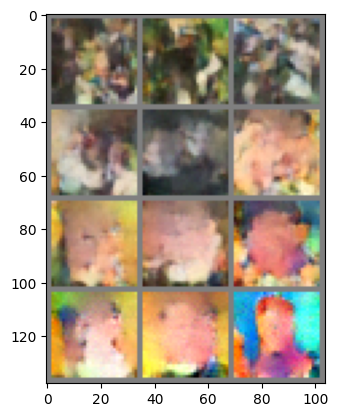

In [ ]:
# Change me
text_list = [
    "A daisy ",
    "A sunflower shine",
    "A rose beautiful"
]
model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
plt.show()


In [ ]:
torch.save(model_flowers.state_dict(), "/kaggle/working/model_flowers.pth")

RuntimeError: Parent directory /kaggle/working does not exist.

In [ ]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
other_utils.save_animation(grids, "/kaggle/working/flowers.gif")